In [ ]:
import tensorflow as tf
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import collections
from gensim.models import word2vec
from keras.utils.vis_utils import plot_model

In [ ]:
drive.mount('/content/drive')  #导入数据集只能使用云端硬盘

Mounted at /content/drive


In [ ]:
train_data=pd.read_csv(open(r"/content/drive/MyDrive/Colab Notebooks/第二轮考核/train.csv"))
test_data=pd.read_csv(open(r"/content/drive/MyDrive/Colab Notebooks/第二轮考核/test.csv"))

In [ ]:
train_data,test_data

In [ ]:
y_train=train_data['label'] #标签值
x_train=train_data['text'] #文本
x_test=test_data['text']

In [ ]:
np.random.seed(100)  #打乱顺序
np.random.shuffle(x_train)
np.random.seed(100)
np.random.shuffle(y_train)

In [ ]:
x_train,x_test

In [ ]:
def pre_processing(sentences): #数据清理：留下小写的单词
  return [re.sub('[^A-Za-z]+',' ',sentence).lower()for sentence in sentences] #正则表达式：不匹配大小写，重复一次或更多次，re.sub把不是字母的替换成空

x_train=pre_processing(x_train)
x_test=pre_processing(x_test)

In [ ]:
x_train[:5],x_test[:5]

In [ ]:
def Sentence_To_Word(sentences): #分词操作：把一个句子分为若干单词
  words = [sentence.split() for sentence in sentences]
  return words

In [ ]:
x_train = Sentence_To_Word(x_train)
x_test = Sentence_To_Word(x_test)

In [ ]:
x_train[:5],x_test[:5]

In [ ]:
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import *  #词的标准化

stemmer = PorterStemmer()

nltk.download('stopwords') #停用词
stop_words = stopwords.words('english') 

#词的清理：过滤停用词 
#并且保持原来的维度
x_train_filtered = []
x_test_filtered = []
for line in x_train:
  filtered_words = []
  for token in line:
    if token not in stop_words:
      filtered_words.append(stemmer.stem(token))
  x_train_filtered.append(filtered_words)

for line in x_test:
  filtered_words = []
  for token in line:
    if token not in stop_words:
      filtered_words.append(stemmer.stem(token))
  x_test_filtered.append(filtered_words)

x_train=x_train_filtered
x_test=x_test_filtered

len(x_train),len(x_test) #前后维度一致

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(8001, 20001)

In [ ]:
sectence_len = [] #训练集句子的长度
for i in range(len(x_train)):
  sectence_len.append(len(x_train[i]))

max(sectence_len)

475

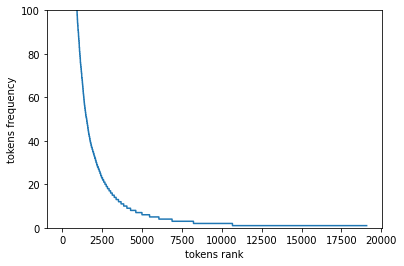

In [ ]:
def count_corpus(tokens): #统计标记的频率：这里的tokens是2D列表
    if isinstance(tokens[0],list):
        # 将tokens展平成使用标记填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

counter = count_corpus(x_train)

token_freq = [] #单词的频率
for i in counter.values():
  token_freq.append(i)

token_freq.sort(reverse=True)
# 画图查看词的频率分布
plt.plot(token_freq)
plt.ylim(0,100)
plt.ylabel('tokens frequency')
plt.xlabel('tokens rank')
plt.show()

In [ ]:
count_corpus(x_train).items()
sorted(counter.items(),key=lambda x:x[1],reverse=True)  #按照出现的频率排序

In [ ]:
class Vocab:
    """构建文本词表"""
    def __init__(self,tokens,min_freq):
        
        # 根据出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(),key=lambda x:x[1],reverse=True)
        
        # 未知标记的索引为0
        self.unk , uniq_tokens = 0, ['<unk>']
        uniq_tokens += [token for token,freq in self.token_freqs
                       if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token,self.token_to_idx = [],dict() # 根据索引找标记和根据标记找索引
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token)-1
            
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        """转换到一个一个的item进行输出"""
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        """如果是单个index直接输出，如果是list或者tuple迭代输出"""
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [ ]:
vocab = Vocab(x_train,1) #训练集的词表
list(vocab.token_to_idx.items())[:8]

In [ ]:
x_train = vocab.__getitem__(x_train)
x_test = vocab.__getitem__(x_test)

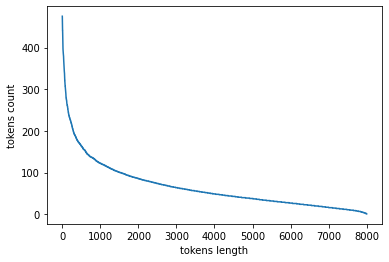

In [ ]:
# 获取每段语句的长度，并画图展示
sectence_len.sort(reverse=True)
# 画图查看词的长度分布
plt.plot(sectence_len)
plt.ylabel('tokens count')
plt.xlabel('tokens length')
plt.show()

# 对训练样本进行padding(填充)和truncating(修剪)

当句子长度满足正态分布的时候，可以取句子长度的平均值并且加上两个标准差，来选用句子的长度

In [ ]:
tokens_length = np.mean(sectence_len) + 2* np.std(sectence_len)
tokens_length

184.03357280874656

 可以看到当句子的长度为184.03357280874656，大约95%的样本被覆盖，我们需要对长度不足的句子进行padding，超长的进行修剪

In [ ]:
np.sum(sectence_len < tokens_length) / len(sectence_len)

0.9551306086739157

In [ ]:
from keras import preprocessing
# 作为特征的单词个数
max_features = 20000

# 在这多单词截断文本（这些单词都属于 max_feature 个最常见的单词）
# 保留文本的长度
# maxlen = int(tokens_length)
maxlen = 100
# 将整数列表转换成形状为 (samples, maxlen) 的二维整数张量
# 过长的截断，过短的补0
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='pre',truncating='pre')
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='pre',truncating='pre')

In [ ]:
x_train[:5]
x_test[:5]

In [ ]:
class CustomDense(tf.keras.layers.Layer):  # 自定义全连接层：继承父类tf.keras.layers.Layer
    def __init__(self, units):
        super(CustomDense, self).__init__()
        self.units = units 

    def build(self, input_shape): #自动执行build操作
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True
        )
        self.b = self.add_weight(
            shape=(self.units,), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

In [ ]:
#参数
embedding_dims = 128
filters = 100
kernel_size = 3
hidden_dims = 64


In [ ]:

model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Embedding(max_features, embedding_dims))

model_cnn.add(tf.keras.layers.Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
#池化
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())


# #增加一个隐藏层:更好分析cnn层提取的特征
model_cnn.add(CustomDense(hidden_dims))

tf.keras.layers.BatchNormalization(), #批标准化
model_cnn.add(tf.keras.layers.Dropout(0.7))
model_cnn.add(tf.keras.layers.Activation('relu'))

#输出层
model_cnn.add(tf.keras.layers.Dropout(0.1))
model_cnn.add(CustomDense(5))
model_cnn.add(tf.keras.layers.Activation('softmax'))
model_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=2)

history1 = model_cnn.fit( 
              x_train,
              y_train,
              batch_size=500,
              epochs=20,
              validation_split=0.1,
              validation_freq=1,
              callbacks=early_stopping
            )

In [ ]:
history_dict = history1.history
history_dict.keys()



acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 

plt.clf()   
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plot_model(model_cnn,show_shapes=True)  #画模型图

In [ ]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 300)         192300    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 custom_dense_4 (CustomDense  (None, 128)              38528     
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 activation_4 (Activation)   (None, 128)              

In [ ]:
embedding_dims = 128
filters = 64
kernel_size = 5
hidden_dims = 64


# Inputs
# input = tf.keras.layers.Input(shape=[int(tokens_length)])
input = tf.keras.layers.Input(shape=100)
# Embeddings layers
x = tf.keras.layers.Embedding(max_features, embedding_dims)(input)

# conv layers
convs = []
for filter_size in [3,4,5]:
    l_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=filter_size, padding='valid', activation='relu', strides=1)(x)
    l_pool = tf.keras.layers.MaxPooling1D()(l_conv)
    l_pool = tf.keras.layers.Flatten()(l_pool)
    convs.append(l_pool)


merge = tf.keras.layers.Concatenate(axis=1)(convs)



# out = tf.keras.layers.Dropout(0.5)(merge)

# output = tf.keras.layers.Dense(32, activation='relu')(out)

# output = tf.keras.layers.Dense(units=2, activation='softmax')(output)



out = tf.keras.layers.Dropout(0.5)(merge)
output = CustomDense(300)(out)
tf.keras.layers.BatchNormalization(), #批标准化
output = tf.keras.layers.Activation('relu')(out)
  
output = CustomDense(5)(output)
output = tf.keras.layers.Activation('softmax')(output)
    



#输出层
model_textcnn = tf.keras.models.Model([input], output)

model_textcnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history2 = model_textcnn.fit( x_train,
              y_train,
              batch_size=500,
              epochs=10,
              validation_split=0.1,
              validation_freq=1
)

In [ ]:
model_textcnn.summary()

In [ ]:
plot_model(model_textcnn,show_shapes=True)

In [ ]:
embedding_dims = 128


model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features,embedding_dims,trainable=True), 

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.LSTM(128, return_sequences=False),
    # tf.keras.layers.SimpleRNN(128),
    
    
    tf.keras.layers.BatchNormalization(), #批标准化
    CustomDense(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Activation('relu'),
    
    CustomDense(5),
    tf.keras.layers.Activation('softmax')
])
model_lstm.compile(optimizer='Adam',
       loss='sparse_categorical_crossentropy',
       metrics=[tf.keras.metrics.Recall]
)


In [ ]:
history3 = model_lstm.fit(  
                x_train,
                y_train,
                batch_size=100,
                epochs=10,
                validation_split=0.1,
                validation_freq=1
         )

In [ ]:
plot_model(model_lstm,show_shapes=True)

In [ ]:
embedding_dims = 128
time_step = 100
filter = 128
kernel_size = 5

model_lstm_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features,
                embedding_dims,
                trainable=True),

    
    tf.keras.layers.Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.BatchNormalization(), #批标准化
    CustomDense(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Activation('relu'),
    
    CustomDense(5),
    tf.keras.layers.Activation('softmax')
])
model_lstm_cnn.compile(optimizer='Adam',
       loss='sparse_categorical_crossentropy',
       metrics=['sparse_categorical_accuracy']
)

In [ ]:
history4 = model_lstm_cnn.fit(x_train,
                y_train,
                batch_size=500,
                epochs=10,
                validation_split=0.1,
                validation_freq=1)

In [ ]:
model_lstm.summary()

In [ ]:
y_test=model_cnn.predict(x_test)

In [ ]:
y_test=model_textcnn.predict(x_test)

In [ ]:
y_test=pd.DataFrame(y_test)

In [ ]:
y_test=np.argmax(y_test.values,axis=1)

In [ ]:
test_data=pd.read_csv(open(r"/content/drive/MyDrive/Colab Notebooks/第二轮考核/test.csv"))
test_data

In [ ]:
y_test = pd.Series(index=test_data['id'].values, data=y_test)

In [ ]:
with open('submission10.csv', 'w') as f:
    f.write('id,label\n')
    for index in y_test.index:
        f.write('{},{}\n'.format(index, y_test[index]))